In [1]:
# !pip install pytorch-lightning
# !pip install transformers
# !pip install vncorenlp

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
!nvidia-smi

Thu Apr  7 01:28:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 32%   53C    P2    47W / 250W |   5526MiB / 11019MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [4]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

train_ratio = 0.8

/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import random

SEED_VALUE = 0
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [6]:
# %cd /content/drive/MyDrive/Colab Notebooks/Multimodal

In [7]:
!ls
data_zip_file = './local1_folder.zip'
# data_zip_file2 = './local2_folder.zip'

csv_file2 = './OUTPUT/Comment_22.csv'
csv_file3 = './OUTPUT/Comment_23.csv'
csv_file4 = './OUTPUT/Comment_24.csv'
csv_file5 = './OUTPUT/Comment_25.csv'

csv_file = './OUTPUT/Comment.csv'

Inception-Copy1.ipynb
Inception.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal.ipynb
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_incept_seed0_bt16_fc_1e-3_1_nofreeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3_1.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3.pth.tar
my_checkpoint_incept_seed0_bt16_fc_only2048_1e-4_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_weight.pth.tar
my_checkpoint_multivoting_freeze_20.pth.tar
my_checkpoint_multivoting_freeze_new_20_af_unfreeze.pth.tar
my_checkpoint_multivoting_freeze_new_20.pth.tar
my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
my_checkpoint_resnet_seed0_bt16_fc_1e-3.pth.tar
OUTPUT
PhoBERT_foody.ipynb
Resnet.ipynb
runs
vncorenlp
VotingMultimodal.ipynb
VotingMultimod

# Data preprocessing

## Image data

In [8]:
data_zip = zipfile.ZipFile(data_zip_file)

In [9]:
len(data_zip.namelist())

58766

In [10]:
'local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg' in data_zip.namelist()

True

local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x734 at 0x7F2D7EE8F010>
(734, 800, 3)


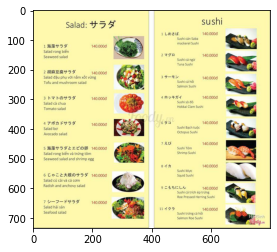

In [11]:
img_path = data_zip.namelist()[1]
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

In [12]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [13]:
data_df1 = pd.read_csv(csv_file)
data_df2 = pd.read_csv(csv_file2)
data_df3 = pd.read_csv(csv_file3)
data_df4 = pd.read_csv(csv_file4)
data_df5 = pd.read_csv(csv_file5)



data_df1[['Comment', 'Rating']].head()

,Comment,Rating
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",1.0


In [14]:
data_df4.shape

(3093, 11)

In [15]:
data_df = pd.concat([data_df1,data_df2,data_df3,data_df4, data_df5], ignore_index = True)

In [16]:
data_df.shape

(14174, 11)

In [17]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)

In [18]:
data_df.isnull().sum()

RevId                   0
UserId                  0
ResId                   0
Comment                 0
image_urls              0
Food_score_cmt          0
Services_score_cmt      0
Atmosphere_score_cmt    0
Position_score_cmt      0
Price_score_cmt         0
Rating                  0
dtype: int64

In [19]:
## Add more data
data_df.rename(columns={"Rating":"score"}, inplace=True)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,Food_score_cmt,Services_score_cmt,Atmosphere_score_cmt,Position_score_cmt,Price_score_cmt,score
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.0,9.0,5.0,5.0,5.0,5.8
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,8.0,9.0
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,10.0,9.4
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,1.0,5.0,5.0,6.0,6.0,4.6
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,1.0,1.0,1.0,1.0,1.0


In [20]:
data_df['image_urls'][0]

'https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-389-637116772226077520.jpg,https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-427-637116772199356351.jpg'

In [21]:
# ## Calculate score
# data_df['score'] = data_df.apply(lambda x: (x['Food_score_cmt']+x['Services_score_cmt']+x['Atmosphere_score_cmt']+x['Position_score_cmt']+x['Price_score_cmt'])/5, axis = 1)
data_df[(data_df['score'] >= 8) & (data_df['score'] <= 8)][['Comment','score']].sort_values(by=['score'])

,Comment,score
8,Giữa cái thời tiết HN sớm trưa mưa nắng thất t...,8.0
9677,Sáng nào mình cx phải ăn phở ở đây ms chịu đc ...,8.0
9701,"Hàng xôi tấp nập người ghé ăn & mua mang đi, n...",8.0
9705,"Quán chè nhỏ nhỏ, đối diện bakery Tati. Cô chủ...",8.0
9713,❤ Vị trí : hàng này mới mở dạo gần đây. Nằm ng...,8.0
...,...,...
4892,* mùa dịch ăn gì ??🤔🤔\nĐang mùa dịch thế này c...,8.0
4907,Suất đặc biệt cơm gà + sườn ship Now,8.0
4955,Chè sầu chính hãng nè cả nhà 😻 viêm họng mà vẫ...,8.0
5034,"Nhân ngày xe bus hỏng đúng quán ding tea, mình...",8.0


In [22]:
data_df['Comment'][8]

'Giữa cái thời tiết HN sớm trưa mưa nắng thất thường, tối phần phật gió như này thì việc ngồi nhâm nhâm nhi nhi em caramen hoa quả này là 1 điều thật tuyệt - thơm thơm ngậy ngậy của caramen, vị thanh mát của các loại hoa quả: dưa hấu, xoài, thanh long, mít....được kết hợp lại với nhau rất thú vị, cốc còn rất là đầy đặn nữa chứ. Cơ mà anh chị chủ quán làm ngon quá đi, cứ bị nghiện ý, mỗi ngày sẽ nếm 1 vị: sữa chua thạch lá nếp nè, sc hoa quả, chè khoai dẻo nè.....chu choa v.v.....vân vân và mây mây...'

In [23]:
## label data
def label_comment(x):
  if x['score'] >= 8:
    return 1
  elif (x['score'] >= 6) & (x['score'] < 8):
    return 2
  else:
    return 0
data_df['label'] = data_df.apply(label_comment, axis=1)

1    6953
2    4194
0    3023
Name: label, dtype: int64


<AxesSubplot:>

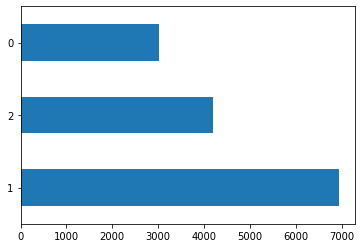

In [24]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [25]:
data_df[['Comment','label', 'score']].head()

,Comment,label,score
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,0,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",1,9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",1,9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,0,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",0,1.0


In [26]:
data_df = data_df.drop(['Food_score_cmt','Services_score_cmt','Atmosphere_score_cmt','Position_score_cmt','Price_score_cmt'],axis=1)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,0


In [27]:
def preprocess_imgpath(df):
    img_p = []
    for path in df['image_urls'].split(","):
        img_path = 'local1_folder-1/' + path.split('/')[-1]
        if img_path in data_zip.namelist():
            img_p.append(img_path)
    if len(img_p) > 0:
        return ','.join(img_p)
    return None

In [28]:
data_df['image_urls'] = data_df.apply(preprocess_imgpath, axis=1)

In [29]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    0
score         0
label         0
dtype: int64

1    6952
2    4194
0    3023
Name: label, dtype: int64


<AxesSubplot:>

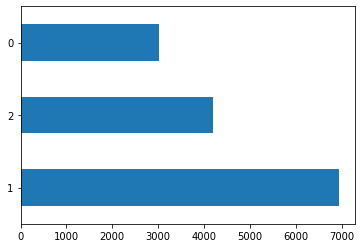

In [30]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [31]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [32]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
punc_re = '[^\w'+uniChars+']'
def preprocess_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  sen = convert_unicode(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower()
  ##Segment
  seg = rdrsegmenter.tokenize(sen)
  if len(seg) == 0:
    sen = ' '
  else: 
    sen = ' '.join(seg[0])
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
data_df['preprocess_comment'] = data_df.apply(lambda x: preprocess_text(x['Comment']), axis = 1)

In [33]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0,đặt dồi sụn của quán vì đọc comment thấy hấp_d...
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1,dồi khá ngon mua về còn nóng mở ra thơm_phức s...
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1,đặt xuất mỳ trộn thập_cẩm khá đầy_đủ và đầy_đặ...
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0,không hiểu sao quán này được 7 9 luôn đặt bánh...
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0,dồi sụn bé tẹo giá quá cao so với các quán khá...


In [34]:
data_df[data_df['preprocess_comment']==" "].shape
# data_df.drop(data_df[data_df['preprocess_comment']==" "].index, inplace = True)

(12, 8)

In [35]:
data_df = data_df.reset_index()
data_df['preprocess_comment'][4187:4191]

4187    chưa bao_giờ phải đăng_nhập để bình_luận về đồ...
4188    ko biết các mẹ đặt ntn nhưng hnay em có gọi su...
4189    hôm_nay mình có vc ko đi ra ngoài ăn đc nên mì...
4190    món iberico cắt từ đùi heo tại bàn đặc_sản của...
Name: preprocess_comment, dtype: object

In [36]:
a = data_df['preprocess_comment'].str.split()
a = a.apply(lambda x: len(x))
a[a==1]

195      1
558      1
714      1
1102     1
1168     1
1452     1
1556     1
1629     1
2200     1
2503     1
2535     1
2642     1
2687     1
3158     1
3163     1
3216     1
3314     1
3510     1
3964     1
3989     1
4021     1
4179     1
4420     1
4903     1
5103     1
6020     1
6128     1
6423     1
6727     1
7239     1
7641     1
7791     1
8273     1
8872     1
9089     1
9432     1
10199    1
10499    1
10559    1
10825    1
11079    1
12357    1
12619    1
13333    1
13540    1
13930    1
Name: preprocess_comment, dtype: int64

In [37]:
a

0         56
1         43
2         38
3         34
4         74
        ... 
14164    107
14165    185
14166     17
14167    319
14168    133
Name: preprocess_comment, Length: 14169, dtype: int64

In [38]:
data_df['Comment'][195]

'Ổn'

<AxesSubplot:>

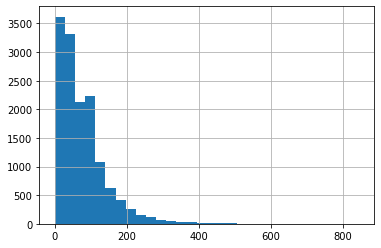

In [39]:
seq_len = [len(i.split()) for i in data_df['preprocess_comment']]

pd.Series(seq_len).hist(bins = 30)

# Load BPE, Vocab of PhoBERT and DataGen

In [40]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [41]:
def collate_batch(batch):
  input_ids = []
  attention_masks = []
  imgs = []
  img_len = []
  labels = []
  for bt in batch:
    input_ids.append(bt[0]['input_ids'][0])
    attention_masks.append(bt[0]['attention_mask'][0])
    imgs.extend(bt[1])
    img_len.append(len(bt[1]))
    labels.append(bt[2])

  bert_tokens = torch.stack(input_ids)
  attention_masks = torch.stack(attention_masks)
  imgs_torch = torch.stack(imgs)
  labels = torch.LongTensor(labels)

  return  { 'input_ids': bert_tokens , 'attention_mask':attention_masks } , imgs_torch, img_len, labels

In [42]:
trans = T.ToTensor()
RANDOM_SEED = 0
MAX_LEN = 150


class SentimentData(Dataset):
  def __init__(self, data, transform = None):
    self.df = data.reset_index(drop=True)
    self.transform = transform
  def __len__(self):
    # print('Size',len(self.df))
    return len(self.df)  
  def __getitem__(self,idx):
    text = self.df["preprocess_comment"][idx]
    text = tokenizer(text, padding='max_length', truncation=True, max_length = MAX_LEN, return_tensors="pt")

    img_list = []
    for path in self.df['image_urls'][idx].split(","):
#       img_path = '/' + path.split('/')[-1]
      img = Image.open(data_zip.open(path))
      if self.transform is not None:
        img = self.transform(img)
      img_list.append(img)

    # print(text.shape)
    # text = ' '.join(text[0])
    label = self.df["label"][idx]

    return (text, img_list, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, data, batch_size: int = 8, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.data = data
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = ''

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.data, test_size = self.test_size, random_state=RANDOM_SEED, stratify = self.data['label'])
      self.test_data, self.val_data = train_test_split(self.val_data,test_size = 0.5, random_state=RANDOM_SEED, stratify = self.val_data['label'])
      print(self.data['label'].value_counts())
      print(self.train_data['label'].value_counts())
      print(self.val_data['label'].value_counts())
      print(self.test_data['label'].value_counts())

  def setup(self, stage = None):
      train_transform = T.Compose([
       T.Resize([299, 299]), T.RandomHorizontalFlip(), T.RandomRotation(10),
        T.ToTensor(),
      ])
      val_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform)
      self.val = SentimentData(self.val_data, val_transform)
      self.test = SentimentData(self.test_data, test_transform)


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, collate_fn=collate_batch)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate_batch)

  def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate_batch)

  

In [43]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(data_df)
  dm.prepare_data()
  dm.setup()
  for step, bat in enumerate(dm.train_dataloader()):
    if step > 0: break
    print(step)
    print(bat[0]['input_ids'].shape)
    print(bat[1].shape)
    print(sum(bat[2]))
    print(len(bat[3]))

1    6952
2    4194
0    3023
Name: label, dtype: int64
1    5562
2    3355
0    2418
Name: label, dtype: int64
1    695
2    419
0    303
Name: label, dtype: int64
1    695
2    420
0    302
Name: label, dtype: int64
0
torch.Size([8, 150])
torch.Size([12, 3, 299, 299])
12
8


In [44]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda:1



# PhoBERT

In [45]:
from transformers import RobertaModel, RobertaConfig, AdamW, AutoModel
from transformers import RobertaForSequenceClassification

pretrained_config_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/config.json"
pretrained_model_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/model.bin"

In [46]:
class Bert_Lstm(nn.Module):
  def __init__(self):
    super(Bert_Lstm, self).__init__()
    self.config = RobertaConfig.from_pretrained(
    'vinai/phobert-base', from_tf=False, output_hidden_states=False)

    self.PhoBERT = RobertaModel.from_pretrained(
    'vinai/phobert-base',
    config=self.config )

    # self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
    self.dense = nn.Linear(768, 768)
    self.dense1 = nn.Linear(768, 128)
    self.dropout = nn.Dropout(0.1)

  
  def forward(self, texts):
    bert_out = self.PhoBERT(texts['input_ids'],token_type_ids=None, attention_mask = texts['attention_mask'])
    bert_out = bert_out['last_hidden_state'][:,0,:]
    x = self.dropout(bert_out)
    x = self.dense(x)
    x = torch.tanh(x)
    x = self.dropout(x)
    feature_extract = self.dense1(x)

    # out, _ = self.lstm(bert_out)
    # feature_extract = out[:,-1,:].contiguous()

    return feature_extract


In [47]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# pho_test
# # oooo = pho_test('iiii')
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [48]:
from torchvision.models import inception_v3

In [49]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)
    self.ffn = nn.Sequential(
                nn.Linear(2048, 512),
                nn.ReLU(),
    #             nn.Dropout(0.1),
                nn.Linear(512, 128),
    #             nn.ReLU(),
    #             nn.Dropout(0.2),
                # nn.Linear(128, 3),
            )

  def process(self, feature, len_img_list):
    max_fea = torch.zeros(len(len_img_list), 2048, feature.shape[-1], feature.shape[-1]).to(device)
    start = 0
    for idx, num in enumerate(len_img_list):
      max_fea[idx] = feature[start:start+num].max(0)[0]
      start += num

    return max_fea
  

  def forward(self, image, len_img_list):
    feature = self.incept_sequen(image)
    feature = self.process(feature, len_img_list)
    feature = self.avgpool(feature)
    feature = self.drop(feature)

    img_fea = feature.reshape(-1, 2048)
    out = self.ffn(img_fea)

    
    return out


In [50]:
# inc = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
# inc

In [51]:
# incept_sequen = nn.Sequential(*list(inc.children())[:-3])
# incept_sequen

In [52]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [53]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [54]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [55]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mrtrongmodel-06/04')

class LRScheduler():
    def __init__(
        self, optimizer, patience=1, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [56]:
class Concatmodal(nn.Module):
  def __init__(self):
    super(Concatmodal,self).__init__()
    # self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
  
  def forward(self, image, inputs, len_img_list, labels=None):
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    image = image.to(device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image, len_img_list)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out


In [57]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100

  counter = 0
  # total = 0
  soft_m = nn.Softmax(dim=-1)

  model.train()
  train_preds = np.array([])
  train_labels = np.array([])

  for i, (texts, images, len_img_list, labels) in enumerate(dm.train_dataloader()):
      counter += 1
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images, texts, len_img_list)
      loss = criterion(outputs, labels)
      output_scores = soft_m(outputs)
      predictions = torch.argmax(output_scores, dim=-1)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
      # _, preds = torch.max(outputs.data, 1)
      predictions = torch.argmax(output_scores, dim=-1)

      predictions = predictions.cpu().numpy()
      labels = labels.cpu().numpy()
      # _, preds = torch.max(outputs.data, 1)
      train_preds = np.concatenate((train_preds, predictions), axis=0)
      train_labels = np.concatenate((train_labels, labels), axis=0)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
            
  train_loss = train_running_loss / counter
  reports = classification_report(train_labels, train_preds, output_dict=True)
  print(confusion_matrix(train_labels, train_preds))
  train_f1 = classification_report(train_labels, train_preds, output_dict=True)['macro avg']['f1-score']
  train_ac = accuracy_score(train_labels, train_preds)

    
#   writer.add_scalar("Loss/train", train_loss, epoch)
#   writer.add_scalar("macro-f1/train", reports['macro avg']['f1-score'], epoch)
#   writer.add_scalar("Acc/train", train_ac, epoch)


  return train_loss, train_ac, train_f1

In [58]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
  val_preds = np.array([])
  val_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (texts, images, len_img_list, labels) in enumerate(dm.val_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts, len_img_list)

        loss = criterion(outputs, labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        val_running_loss += loss.item()
        
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()
        val_preds = np.concatenate((val_preds, predictions), axis=0)
        val_labels = np.concatenate((val_labels, labels), axis=0)
    

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  print(confusion_matrix(val_labels, val_preds))
  val_ac = accuracy_score(val_labels, val_preds)
  val_f1 = classification_report(val_labels, val_preds, output_dict=True)['macro avg']['f1-score']

#   writer.add_scalar("Loss/val", val_loss, epoch)
#   writer.add_scalar("Acc/val", val_ac, epoch)
#   writer.add_scalar("macro-f1/val", val_f1, epoch)
  
  return val_loss, val_ac, val_f1


In [59]:

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)

  soft_m = nn.Softmax(dim=-1)


  with torch.no_grad():
    for i, (texts, images, inputs, labels) in enumerate(dm.test_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts, inputs)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
  test_preds = test_preds.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
       
  print('test', classification_report(test_labels, test_preds))
  print('test_ac', accuracy_score(test_labels, test_preds))
  print('Confusion', confusion_matrix(test_labels, test_preds))
  print('Macro_f1', classification_report(test_labels, test_preds, output_dict=True)['macro avg']['f1-score'])
  
  # test_loss = test_running_loss / counter



In [60]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [61]:
# testing(mo, dm)

In [62]:
def save_checkpoint(state, filename='my_checkpoint_multi_modal_mrTrong_unfreeze_weight.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [63]:
def save_checkpoint1(state, filename='my_checkpoint_multi_modal_mrTrong_unfreeze_f1_weight.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [64]:
%ls

Inception-Copy1.ipynb
Inception.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal.ipynb
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_incept_seed0_bt16_fc_1e-3_1_nofreeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3_1.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3.pth.tar
my_checkpoint_incept_seed0_bt16_fc_only2048_1e-4_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_weight.pth.tar
my_checkpoint_multivoting_freeze_20.pth.tar
my_checkpoint_multivoting_freeze_new_20_af_unfreeze.pth.tar
my_checkpoint_multivoting_freeze_new_20.pth.tar
my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
my_checkpoint_resnet_seed0_bt16_fc_1e-3.pth.tar
OUTPUT/
PhoBERT_foody.ipynb
Resnet.ipynb
runs/
vncorenlp/
VotingMultimodal.ipynb
VotingMulti

In [65]:
# model = Concatmodal()
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [66]:
def freeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = False
  for param in model.incept.incept.parameters():
    param.requires_grad = False
  return model

def unfreeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = True
  for param in model.incept.incept.parameters():
    param.requires_grad = True
    # print(param)
  return model

In [67]:
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [68]:
# import gc
# del model
# gc.collect()

In [69]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(dm.train_data['label']), y=dm.train_data['label'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [71]:
model = Concatmodal()
model = freeze(model)
model.to(device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Concatmodal(
  (BERT): Bert_Lstm(
    (PhoBERT): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=1)
        (position_embeddings): Embedding(258, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [72]:
from torch.optim import lr_scheduler


train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]

#define model
# model = Concatmodal()
# model = freeze(model)
# model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# define hyper
# grouped_params = [
#     {"params": [p for n, p in roberta_params], "lr": 1e-5},
#     # {"params": [p for n, p in classifier_params], "lr": 3e-3}
# ]
optimizer = torch.optim.Adam([
        {'params': model.incept.ffn.parameters()},  
        {'params': model.dense.parameters()},       
        {'params': model.cl.parameters()},   
        {'params': model.BERT.dense.parameters()},
        {'params': model.BERT.dense1.parameters()},
        {'params': model.BERT.PhoBERT.parameters(), 'lr': 2e-5},
        {'params': model.incept.incept.parameters(), 'lr': 1e-4}
    ], lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
#training
# def training(model, optimizer):
# define hyper
criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
epochs = 20
# lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
min_loss = np.Inf
max_f1 = 0

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_epoch_ac, train_f1 = fit(
        model, dm, criterion, optimizer, epoch
    )
  writer.flush()

  val_epoch_loss, val_epoch_ac, val_f1 = validation(
        model, dm, criterion
    )
  writer.flush()

#   lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f"Train acc: {train_epoch_ac:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_f1)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_f1)
  epoch_list.append(epoch)

  if (min_loss >= val_epoch_loss):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss':val_epoch_loss, 'f1': val_f1}
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)
        
  if (max_f1 <= val_f1):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss':val_epoch_loss, 'f1': val_f1}
      print('Better f1 ver saved')
      max_f1 = val_f1    
      save_checkpoint1(checkpoint)

testing(model, dm)

160,703,179 total parameters.
1,870,339 training parameters.
Epoch 0 of 20
Epoch 0 Step 99 ave_loss 0.9383
Epoch 0 Step 199 ave_loss 0.8249
Epoch 0 Step 299 ave_loss 0.7759
Epoch 0 Step 399 ave_loss 0.8018
Epoch 0 Step 499 ave_loss 0.7590
Epoch 0 Step 599 ave_loss 0.7828
Epoch 0 Step 699 ave_loss 0.7869
[[1804  269  345]
 [ 614 3399 1549]
 [ 521  986 1848]]
              precision    recall  f1-score   support

         0.0       0.56      0.89      0.69       303
         1.0       0.82      0.61      0.70       695
         2.0       0.56      0.56      0.56       419

    accuracy                           0.65      1417
   macro avg       0.65      0.69      0.65      1417
weighted avg       0.69      0.65      0.65      1417

[[271  15  17]
 [107 422 166]
 [110  76 233]]
Train Loss: 0.8080
Train acc: 0.6221
Val Loss: 0.6953
Val Acc: 0.6535
Better ver saved
Saving....my_checkpoint_multi_modal_mrTrong_freeze_weight.pth.tar
Better f1 ver saved
Saving....my_checkpoint_multi_modal_mrTr

In [ ]:
# training(model, optimizer)
print(next(model.parameters()).device)

In [78]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [74]:
from torch.optim import lr_scheduler


train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]

#define model
# model = Concatmodal()
# model = freeze(model)
# model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

criterion = nn.CrossEntropyLoss(weight=class_weights)
epochs = 20
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
min_loss = np.Inf
max_f1 = 0

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_epoch_ac, train_f1 = fit(
        model, dm, criterion, optimizer, epoch
    )
#   writer.flush()

  val_epoch_loss, val_epoch_ac, val_f1 = validation(
        model, dm, criterion
    )
#   writer.flush()

  lr_scheduler(val_f1)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f"Train acc: {train_epoch_ac:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_f1)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_f1)
  epoch_list.append(epoch)

  if (min_loss >= val_epoch_loss):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss':val_epoch_loss, 'f1': val_f1}
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)
        
  if (max_f1 <= val_f1):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss':val_epoch_loss, 'f1': val_f1}
      print('Better f1 ver saved')
      max_f1 = val_f1    
      save_checkpoint1(checkpoint)

testing(model, dm)

160,703,179 total parameters.
136,868,611 training parameters.
Epoch 0 of 20
Epoch 0 Step 99 ave_loss 0.7337
Epoch 0 Step 199 ave_loss 0.7366
Epoch 0 Step 299 ave_loss 0.6768
Epoch 0 Step 399 ave_loss 0.6947
Epoch 0 Step 499 ave_loss 0.6818
Epoch 0 Step 599 ave_loss 0.6906
Epoch 0 Step 699 ave_loss 0.7158
Epoch 0 Step 799 ave_loss 0.6511
Epoch 0 Step 899 ave_loss 1.0804
Epoch 0 Step 999 ave_loss 1.0409
Epoch 0 Step 1099 ave_loss 1.0197
Epoch 0 Step 1199 ave_loss 1.0179
Epoch 0 Step 1299 ave_loss 1.0151
Epoch 0 Step 1399 ave_loss 1.0278
[[1600  439  379]
 [ 773 3466 1323]
 [ 528 1134 1693]]
              precision    recall  f1-score   support

         0.0       0.40      0.63      0.49       303
         1.0       0.58      0.61      0.59       695
         2.0       0.52      0.27      0.35       419

    accuracy                           0.51      1417
   macro avg       0.50      0.50      0.48      1417
weighted avg       0.52      0.51      0.50      1417

[[190  92  21]
 [193 4

KeyboardInterrupt: 

In [90]:
import gc
del model 
gc.collect()

778

In [92]:
torch.cuda.empty_cache()

In [93]:
!nvidia-smi

Thu Apr  7 01:27:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   55C    P2    86W / 250W |   5526MiB / 11019MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [70]:
PATH = "my_checkpoint_multi_modal_mrTrong_freeze_f1_weight.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
model = Concatmodal()
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
print(checkpoint['epoch'])

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


4


In [71]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

160,703,179 total parameters.
160,703,179 training parameters.


In [72]:
def freeze(model):  
#   for param in model.BERT.PhoBERT.parameters():
#     param.requires_grad = False
  for param in model.incept.incept.parameters():
    param.requires_grad = False
    # print(param)
  return model

model = freeze(model)

In [73]:
optimizer = torch.optim.Adam([
        {'params': model.incept.ffn.parameters()},  
        {'params': model.dense.parameters()},       
        {'params': model.cl.parameters()},   
        {'params': model.BERT.dense.parameters()},
        {'params': model.BERT.dense1.parameters()},
        {'params': model.BERT.PhoBERT.parameters(), 'lr': 2e-5},
        {'params': model.incept.incept.parameters(), 'lr': 1e-4}
    ], lr=1e-4)
optimizer
# optimizer.load_state_dict(checkpoint['optimizer'])

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 3
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 4
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 5
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 2e-05
    maximize: False
    weight_decay: 0

Parameter Group 6
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [75]:
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.84      0.77      0.81       302
         1.0       0.75      0.83      0.79       695
         2.0       0.63      0.55      0.59       420

    accuracy                           0.74      1417
   macro avg       0.74      0.72      0.73      1417
weighted avg       0.73      0.74      0.73      1417

test_ac 0.7374735356386732
Confusion [[233  31  38]
 [ 14 580 101]
 [ 29 159 232]]
Macro_f1 0.7282121629630188


In [76]:
checkpoint['optimizer']

{'state': {0: {'step': 3545,
   'exp_avg': tensor([[ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
             5.6052e-45,  5.6052e-45],
           [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
             5.6052e-45,  5.6052e-45],
           [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
            -5.6052e-45, -5.6052e-45],
           ...,
           [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
             5.6052e-45,  5.6052e-45],
           [ 9.4547e-04,  5.5210e-04,  6.4259e-05,  ...,  2.6656e-03,
             5.8739e-04,  4.3998e-04],
           [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
             5.6052e-45,  5.6052e-45]], device='cuda:1'),
   'exp_avg_sq': tensor([[3.4968e-11, 1.2886e-10, 2.1474e-10,  ..., 3.1856e-10, 1.6988e-10,
            2.3086e-10],
           [5.5433e-09, 1.0802e-08, 9.4702e-09,  ..., 4.2254e-09, 1.2383e-08,
            1.0670e-08],
           [4.6705e-12, 3.8471e-11, 7.2376e-11,  ..

In [ ]:
import cv2
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.test_dataloader()):
        labels = labels.to(device)

        outputs = model(images, texts)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        for t in texts:
          test_text.append(t) 
        for i in images:
          test_img.append(i) 

    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label, text in zip(test_img, test_labels, test_preds, test_text):

      if (actual_label == label):

        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Text: {}...\n Actual: {}\n Predicted: {}".format(text[:30], actual_label, label))
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
  plt.savefig('res_freeze_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


In [80]:
torch.cuda.empty_cache()

In [81]:
!nvidia-smi

Wed Apr  6 21:41:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   41C    P8     1W / 250W |   2368MiB / 11019MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

# Multimodal

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

class Multimodal(pl.LightningModule):
  def __init__(self, lr_multi, lr_classifier):
    super(Multimodal,self).__init__()
    self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    self.lr_multi = lr_multi
    self.lr_classifier = lr_classifier

    # self.model = self._build_model()
    # self.trainer_params = self._get_trainer_params()

  def forward(self, image, texts, labels=None):
    inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
    # b_labels = None
    # b_labels = labels.to(self.device)

    for key in inputs:
        inputs[key] = inputs[key].to(self.device)
    image = image.to(self.device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out
  
  def configure_optimizers(self):
    roberta_params = self.BERT.parameters()
    inception_params = self.incept.parameters()
    dense_params = self.dense.parameters()
    classifier_params = self.cl.parameters()

    # for n,p in classifier_params:
    #   print(n,p)

    # grouped_params = [
    #     {"params": roberta_params, "lr": self.lr_multi},
    #     {"params": inception_params, "lr": self.lr_multi},
    #     {"params": dense_params, "lr": self.lr_multi},
    #     {"params": classifier_params, "lr": self.lr_classifier}
    # ]
    # optimizer = torch.optim.AdamW(
    #     grouped_params
    # )
    optimizer = torch.optim.AdamW(
              self.parameters(), 
              lr = 0.001
          )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


  def training_step(self, batch, batch_idx):
    texts, images, labels = batch
    preds = self(images, texts, labels)
    labels = labels.to(self.device)

    loss = self.loss_module(preds, labels)

    return loss
  
  def validation_step(self, batch, batch_idx):
    texts, images, labels = batch
    logits = self(images, texts, labels)

    loss = self.loss_module(logits, labels)
    output_scores = torch.softmax(logits, dim=-1)

    return loss, output_scores, labels

  def validation_epoch_end(self, validation_step_outputs):
    val_preds = torch.tensor([], device=self.device)
    val_scores = torch.tensor([], device=self.device)
    val_labels = torch.tensor([], device=self.device)
    val_loss = 0
    total_item = 0

    for idx, item in enumerate(validation_step_outputs):
        loss, output_scores, labels = item

        predictions = torch.argmax(output_scores, dim=-1)
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)

        val_loss += loss
        total_item += 1

    # print("VAL PREDS", val_preds.shape)
    # print("VAL SCORES", val_scores.shape)
    # print("VAL LABELS", val_labels.shape)
    val_preds = val_preds.cpu().numpy()
    val_scores = val_scores.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    # reports = classification_report(val_labels, val_preds, output_dict=True)
    print("VAL PREDS", val_preds)
    print("VAL LABELS", val_labels)
    print("VAL SCORES", val_scores)
    # try:
    #     auc = roc_auc_score(val_labels, val_scores)
    # except Exception as e:
    #     print(e)
    #     print("Cannot calculate AUC. Default to 0")
    #     auc = 0
    accuracy = accuracy_score(val_labels, val_preds)

    print(classification_report(val_labels, val_preds))

    self.log("loss/val", val_loss)
    # self.log("auc/val", auc)
    self.log("accuracy/val", accuracy)
    # self.log("precision/val", reports["weighted avg"]["precision"])
    # self.log("recall/val", reports["weighted avg"]["recall"])
    # self.log("f1/val", reports["weighted avg"]["f1-score"])




In [ ]:
# trainer = pl.Trainer(
#     fast_dev_run=True,
# )
# multi = Multimodal(lr_multi=1e-5, lr_classifier=3e-3)
# dm = SentimentDataModule(data_df)
# trainer.fit(multi, dm)


In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/Colab Notebooks/Multimodal/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(multi, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/default

  | Name        | Type             | Params
-------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0     
1 | BERT        | Bert_Lstm        

Validation sanity check: 0it [00:00, ?it/s]

VAL PREDS [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2.]
VAL LABELS [1. 2. 0. 0. 2. 2. 2. 2. 0. 2. 1. 0. 1. 1. 1. 1. 0. 2. 2. 1. 2. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 0. 1.]
VAL SCORES [0.2503872  0.25511816 0.33502465 0.233994   0.2737939  0.30235466
 0.30597535 0.28478307 0.34449401 0.28433585 0.3386114  0.24622746
 0.2953767  0.28849763 0.32898384 0.27177638 0.2833459  0.30263612
 0.31047884 0.24584286 0.32877764 0.25412712 0.20685947 0.29209316
 0.30371505 0.292875   0.31025544 0.36505568 0.30896547 0.29549003
 0.30231565 0.30986333]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      0.08      0.14        12
         2.0       0.41      0.86      0.56        14

    accuracy                           0.41        32
   macro avg       0.30      0.31      0.23        32
weighted avg       0.37      0.41      0.30        32



Training: 0it [00:00, ?it/s]

AssertionError: ignored

In [ ]:
# multi

In [ ]:
# from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


# class Concatmodal(nn.Module):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Concatmodal,self).__init__()
#     self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier
  
#   def forward(self, image, texts, labels=None):
#     inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # b_labels = None
#     # b_labels = labels.to(self.device)

#     for key in inputs:
#         inputs[key] = inputs[key].to(self.device)
#     image = image.to(self.device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out
  

# class Multimodal(pl.LightningModule):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Multimodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     # self.BERT = Bert_Lstm()
#     # self.incept = Inception()
#     # self.dense = nn.Linear(256,256)
#     # self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier

#     self.model = self._build_model()
#     # self.trainer_params = self._get_trainer_params()

#   def forward(self, image, texts, labels=None):
#     # inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # # b_labels = None
#     # # b_labels = labels.to(self.device)

#     # for key in inputs:
#     #     inputs[key] = inputs[key].to(self.device)
#     # image = image.to(self.device)

#     # fea1 = self.BERT(inputs)
#     # fea2 = self.incept(image)
#     # cat = torch.cat((fea1, fea2), 1)
#     # out = self.model(cat)

#     return self.model(image, texts)
  
#   def _build_model(self):
#     return Concatmodal(self.lr_multi, self.lr_classifier)
  
#   def configure_optimizers(self):
#     # roberta_params = self.BERT.parameters()
#     # inception_params = self.incept.parameters()
#     # dense_params = self.dense.parameters()
#     # classifier_params = self.cl.parameters()

#     # for n,p in classifier_params:
#     #   print(n,p)

#     # grouped_params = [
#     #     {"params": roberta_params, "lr": self.lr_multi},
#     #     {"params": inception_params, "lr": self.lr_multi},
#     #     {"params": dense_params, "lr": self.lr_multi},
#     #     {"params": classifier_params, "lr": self.lr_classifier}
#     # ]
#     # optimizer = torch.optim.AdamW(
#     #     grouped_params
#     # )
#     optimizer = torch.optim.AdamW(
#               self.model.parameters(), 
#               lr = 0.001
#           )

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


#   def training_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     preds = self(images, texts, labels)

#     loss = self.loss_module(preds, labels)

#     print("train_loss", loss)
#     return loss
  
#   def validation_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     logits = self(images, texts, labels)

#     loss = self.loss_module(logits, labels)
#     output_scores = torch.softmax(logits, dim=-1)

#     return loss, output_scores, labels

#   def validation_epoch_end(self, validation_step_outputs):
#     val_preds = torch.tensor([], device=self.device)
#     val_scores = torch.tensor([], device=self.device)
#     val_labels = torch.tensor([], device=self.device)
#     val_loss = 0
#     total_item = 0

#     for idx, item in enumerate(validation_step_outputs):
#         loss, output_scores, labels = item

#         predictions = torch.argmax(output_scores, dim=-1)
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)

#         val_loss += loss
#         total_item += 1

#     # print("VAL PREDS", val_preds.shape)
#     # print("VAL SCORES", val_scores.shape)
#     # print("VAL LABELS", val_labels.shape)
#     val_preds = val_preds.cpu().numpy()
#     val_scores = val_scores.cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

#     # reports = classification_report(val_labels, val_preds, output_dict=True)
#     print("VAL PREDS", val_preds)
#     print("VAL LABELS", val_labels)
#     print("VAL SCORES", val_scores)
#     # try:
#     #     auc = roc_auc_score(val_labels, val_scores)
#     # except Exception as e:
#     #     print(e)
#     #     print("Cannot calculate AUC. Default to 0")
#     #     auc = 0
#     accuracy = accuracy_score(val_labels, val_preds)

#     print(classification_report(val_labels, val_preds))

#     self.log("loss/val", val_loss)
#     # self.log("auc/val", auc)
#     self.log("accuracy/val", accuracy)
#     # self.log("precision/val", reports["weighted avg"]["precision"])
#     # self.log("recall/val", reports["weighted avg"]["recall"])
#     # self.log("f1/val", reports["weighted avg"]["f1-score"])


